# How to use KITTI scan unfolding

Make sure to install package `unfolding` first.
```
pip install git+https://github.com/ltriess/kitti_scan_unfolding
```

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import unfolding

In [2]:
data_dir = os.path.join(os.getcwd(), "data")  # path to sample data

Load the raw KITTI data from the binary file.
Given are N points with x, y, z, and remission.

Beware, this code only works for the raw KITTI point clouds saved in their original format. It is not suitable for ego-motion corrected data, neither for any other datasets.

In [3]:
file = os.path.join(data_dir, "sample_raw.bin")
scan = np.fromfile(file, dtype=np.float32).reshape((-1, 4))
print("scan", scan.shape, scan.dtype)

points = scan[:, :3]
remissions = scan[:, 3]
print("--> points {}, remissions {}".format(points.shape, remissions.shape))

scan (124668, 4) float32
--> points (124668, 3), remissions (124668,)


## Using custom projection

You can simply use `unfolding` to get the indices for the respective rows and columns with `get_kitti_rows()` and `get_kitti_columns()`.
You can now proceed with your custom projection mechanism.
The package also provides a complete projection into the image-like structure (see next section).


In [4]:
rows = unfolding.get_kitti_rows(points)
columns = unfolding.get_kitti_columns(points)

print("rows shape: {}, min: {}, max: {}".format(rows.shape, np.min(rows), np.max(rows)))
print("cols shape: {}, min: {}, max: {}".format(rows.shape, np.min(columns), np.max(columns)))

# Put your own projection here.

rows shape: (124668,), min: 0, max: 63
cols shape: (124668,), min: 0, max: 1999


## Using `unfolding` projection

The default image size for KITTI is `(64, 2000)` for one 360 degree scan. This is due to the number of layers of the sensor and the revolution at 10Hz.

In [5]:
image_size = (64, 2000)
projection = unfolding.projection(points, image_size=image_size)

The function returns a dictionary.
The dictionary contains the projected input points under the key `points`.
But it also returns additional useful information, as described below.

### Get the projected points and depth

In [6]:
proj_points = projection["points"]  # the projected points
proj_depth = projection["depth"]  # the projected depth

print("key 'points' {} {} --> projection of the point cloud".format(proj_points.shape, proj_points.dtype))
print("key 'depth'  {} {} --> projected depth".format(proj_depth.shape, proj_depth.dtype))

key 'points' (64, 2000, 3) float32 --> projection of the point cloud
key 'depth'  (64, 2000) float32 --> projected depth


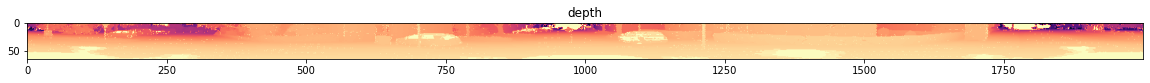

In [7]:
# Visualization the projected depth.
plt.figure(figsize=(20, 4))
plt.imshow(proj_depth, cmap="magma_r")
plt.title("depth")
plt.show()

### Get projection information

Sometimes it is useful to know to which location a point has been projected or how to restore the original point list from the image-like projection.
The following three channels `indices`, `inverse`, and `active` provide all information for transformations in both directions.

In [8]:
indices = projection["indices"]  # the image location for each point it is projected into
inverse = projection["inverse"]  # the index of the respective point in the point cloud for each image location
active = projection["active"]  # whether a point is actively used in the projection (multiple point occlusions)

print("key 'indices' {} {} --> row and column indices for each point".format(indices.shape, indices.dtype))
print("key 'inverse' {} {} --> point indices for each projected location".format(inverse.shape, inverse.dtype))
print("key 'active'  {} {} --> activity flag in the projection for each point".format(active.shape, active.dtype))

key 'indices' (124668, 2) int32 --> row and column indices for each point
key 'inverse' (64, 2000) int32 --> point indices for each projected location
key 'active'  (124668,) bool --> activity flag in the projection for each point


### Project additional channels

In case you wondered if I forgot about the `remissions`: no I did not.
The function offers the possibility to feed any number of additional channels into.
The channels will then be projected in the same way as `points`.
It is necessary that all channels have the same first dimension size as `points`.

Take a look at how to add `remissions` to the projection function.

In [9]:
projection = unfolding.projection(points, remissions, image_size=image_size)
proj_channels = projection["channels"]

The function returns a list of the projections of all additional channels.
We added one additional channel, i.e. `remissions`, therefore `len(proj_channels) == 1`.

In [10]:
proj_remissions = proj_channels[0]
print("remissions", remissions.shape, remissions.dtype, "-->", proj_remissions.shape, proj_remissions.dtype)

remissions (124668,) float32 --> (64, 2000) float32


If you are using the SemanticKITTI dataset with point-wise labels, simply add them as additional channels to the function.

In [11]:
file = os.path.join(data_dir, "sample.label")
labels = np.fromfile(file, dtype=np.int32)
labels = labels.reshape((-1))

semantic_ids = labels & 0xFFFF
instance_ids = labels >> 16

projection = unfolding.projection(points, remissions, semantic_ids, instance_ids, image_size=image_size)
proj_depth = projection["depth"]
proj_channels = projection["channels"]

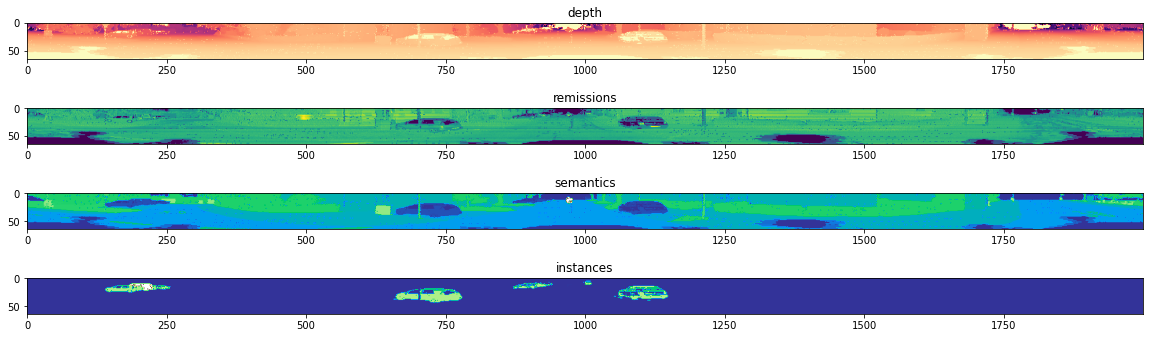

In [12]:
# Visualization of the additional channels.
fig = plt.figure(figsize=(20, 6))
ax0 = fig.add_subplot(411)
ax1 = fig.add_subplot(412)
ax2 = fig.add_subplot(413)
ax3 = fig.add_subplot(414)
ax0.imshow(proj_depth, cmap="magma_r")
ax1.imshow(proj_channels[0], cmap="viridis")
ax2.imshow(proj_channels[1], cmap="terrain")
ax3.imshow(proj_channels[2], cmap="terrain")
ax0.title.set_text("depth")
ax1.title.set_text("remissions")
ax2.title.set_text("semantics")
ax3.title.set_text("instances")
plt.show()

## Testing with ego-motion corrected data

Take a look at [README.md](data/README.md) for more information on the difference between `sample_raw.bin` and `sample_ego.bin`.

In [13]:
file = os.path.join(data_dir, "sample_ego.bin")
scan = np.fromfile(file, dtype=np.float32).reshape((-1, 4))

rows = unfolding.get_kitti_rows(scan[:, :3])
columns = unfolding.get_kitti_columns(scan[:, :3])

The functions do not perform any check or print out warnings.
However, looking at the output ranges, you can see that we receive more rows than the sensor has layers.
The number of columns is correct, since the function simply divides the data into equal bins over 360 degree.

In [14]:
print("rows shape: {s}, min: {min}, max: {max}".format(s=rows.shape, min=np.min(rows), max=np.max(rows)))
print("cols shape: {s}, min: {min}, max: {max}".format(s=rows.shape, min=np.min(columns), max=np.max(columns)))

rows shape: (124668,), min: 0, max: 115
cols shape: (124668,), min: 0, max: 1999
